In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import matplotlib.ticker as mtick
from scipy import stats
pd.set_option('display.max_columns', None)

from scipy.stats import skew, kurtosis

import pygris
from shapely.geometry import Polygon

import geopandas as gpd
from shapely.geometry import Polygon
from itertools import product
import warnings
warnings.filterwarnings("ignore")

import shapely
from shapely.ops import unary_union

In [2]:
chunk_size = 50000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 300000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/zipcode_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)
    
# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
zipcode_df = pd.concat(gdf_list, ignore_index=True)

In [3]:
zipcode_df.head()

,ZIPcode,geometry,year
0,99519,"POLYGON ((-148.34155 70.25088, -148.34207 70.2...",2016
1,99519,"POLYGON ((-148.34155 70.25088, -148.34207 70.2...",2015
2,99519,"POLYGON ((-148.34155 70.25088, -148.34207 70.2...",2014
3,99519,"POLYGON ((-148.49985 70.29307, -148.49996 70.2...",2012
4,99519,"POLYGON ((-148.49985 70.29307, -148.49996 70.2...",2013


In [4]:
def create_union_and_flag(df, year_1, year_2, new_year):
    df_year_1 = df[df['year'] == year_1]
    df_year_2 = df[df['year'] == year_2]

    new_geometries = []

    unique_zipcodes = set(df_year_1['ZIPcode']).union(df_year_2['ZIPcode'])

    for zipcode in unique_zipcodes:
        geom_year_1 = df_year_1.loc[df_year_1['ZIPcode'] == zipcode, 'geometry'].unary_union if zipcode in df_year_1['ZIPcode'].values else None
        geom_year_2 = df_year_2.loc[df_year_2['ZIPcode'] == zipcode, 'geometry'].unary_union if zipcode in df_year_2['ZIPcode'].values else None

        if geom_year_1 is not None and geom_year_2 is not None:
            new_geometry = unary_union([geom_year_1, geom_year_2])
            flag = None
        elif geom_year_1 is not None:
            new_geometry = geom_year_1
            flag = f'only{year_1}'
        elif geom_year_2 is not None:
            new_geometry = geom_year_2
            flag = f'only{year_2}'
        else:
            continue

        new_geometries.append({'ZIPcode': zipcode, 'geometry': new_geometry, 'year': new_year, 'flag': flag})

    return new_geometries

In [5]:
# Apply the function for the year pairs 2000-2010 and 2010-2012
new_geometries_2005 = create_union_and_flag(zipcode_df, 2000, 2010, 2005)
new_geometries_2011 = create_union_and_flag(zipcode_df, 2010, 2012, 2011)

# Convert the lists to GeoDataFrames
new_geometries_2005_df = gpd.GeoDataFrame(new_geometries_2005)
new_geometries_2011_df = gpd.GeoDataFrame(new_geometries_2011)

# Concatenate these with the original dataframe
zipcode_df = pd.concat([zipcode_df, new_geometries_2005_df, new_geometries_2011_df], ignore_index=True)

# Make sure the dataframe is still a GeoDataFrame
zipcode_df = gpd.GeoDataFrame(zipcode_df)

# Set 'flag' to NaN for all rows except where 'year' is 2005 or 2011
zipcode_df['flag'] = zipcode_df.apply(lambda x: x[''] if x['year'] in [2005, 2011] else None, axis=1)

In [20]:
zipcode_df[zipcode_df['year']==2005].head()

,ZIPcode,geometry,year,flag
292622,63121,"POLYGON ((-90.31256 38.72829, -90.31285 38.729...",2005,None
292623,94112,"POLYGON ((-122.45568 37.73139, -122.45550 37.7...",2005,None
292624,38625,"MULTIPOLYGON (((-88.83762 34.54875, -88.83753 ...",2005,None
292625,43611,"POLYGON ((-83.50880 41.68799, -83.50967 41.690...",2005,None
292626,97530,"POLYGON ((-123.15361 42.00821, -123.15378 42.0...",2005,None


Plotting data for year 2000 - Area: 0.0021251148850000255
Plotting data for year 2005 - Area: 0.0029577996735001715
Plotting data for year 2010 - Area: 0.0028356508165001126


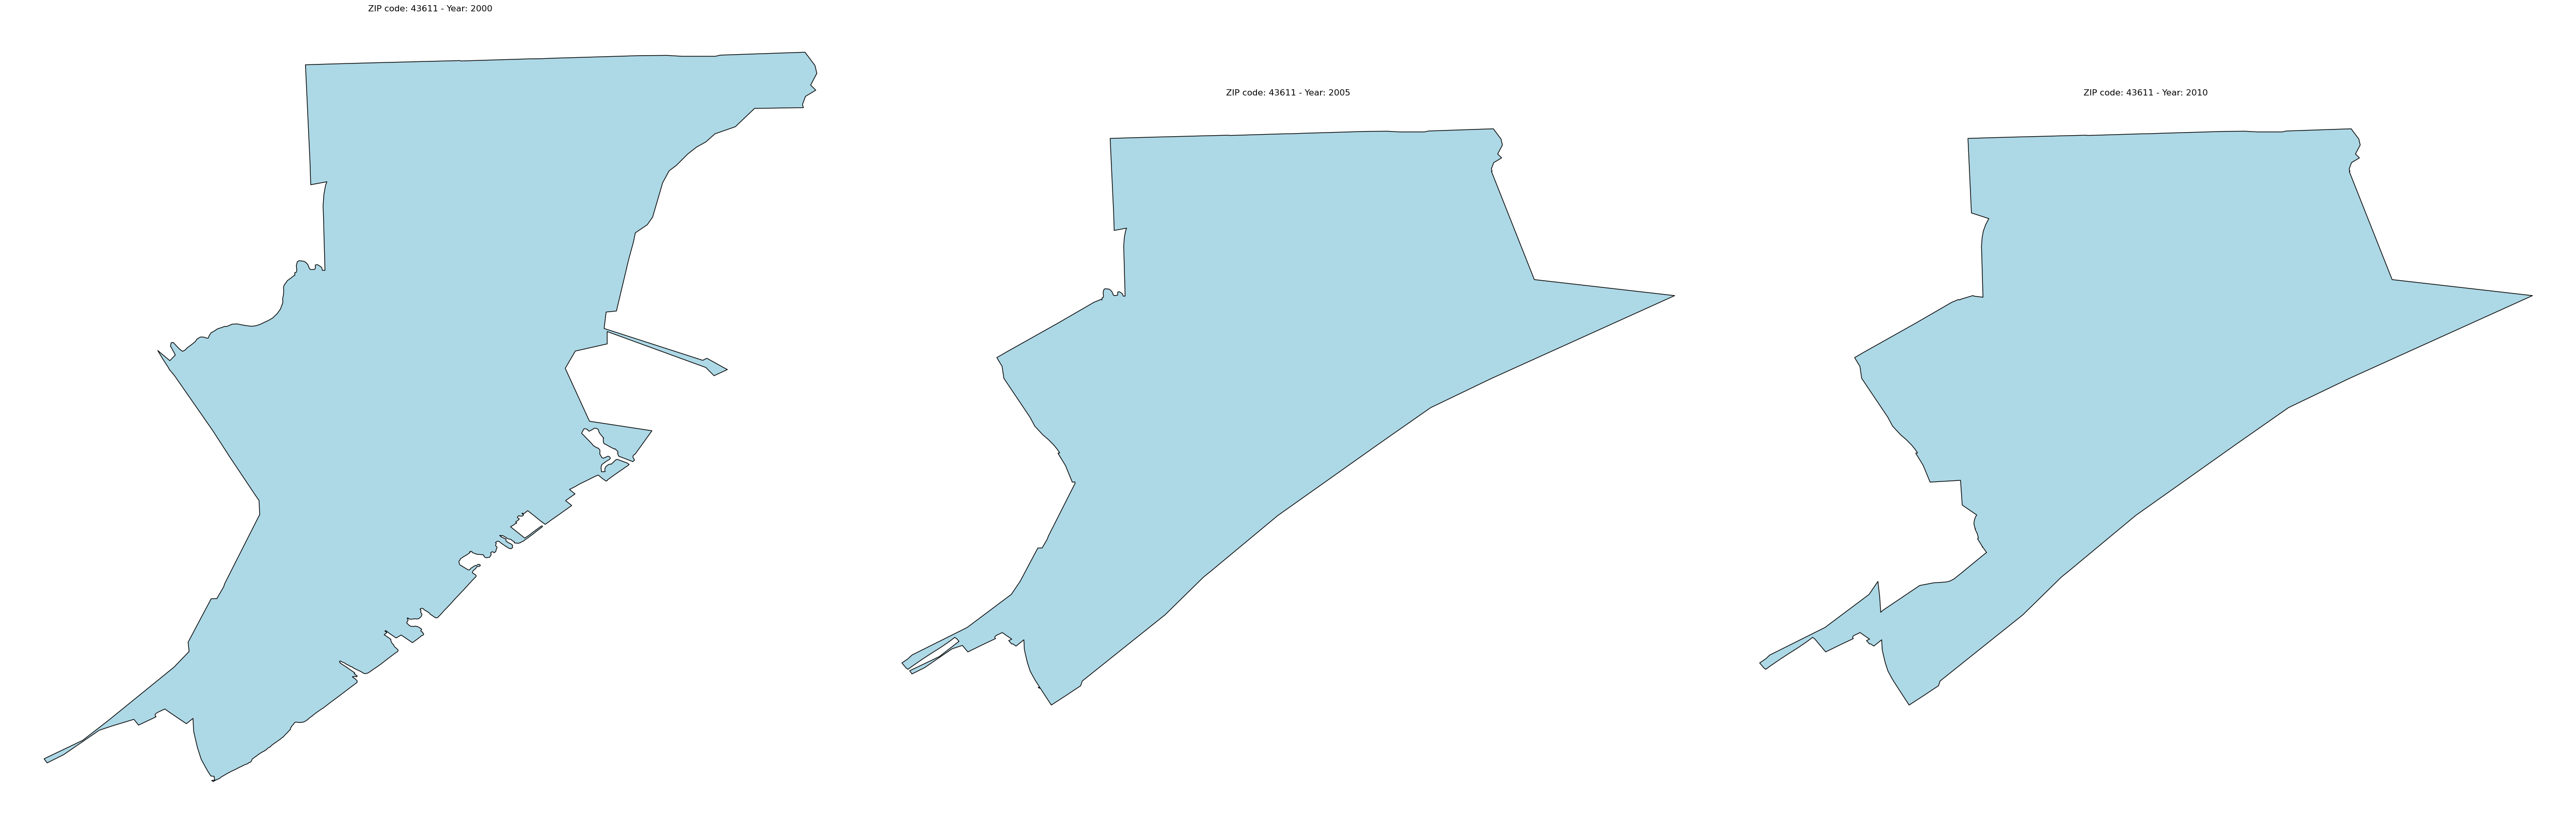

In [34]:
target_zipcode = '43611'
target_years = [2000, 2005, 2010]

fig, axes = plt.subplots(1, 3, figsize=(50, 45))

for i, year in enumerate(target_years):
    data = zipcode_df[(zipcode_df['ZIPcode'] == target_zipcode) & (zipcode_df['year'] == year)]

    if not data.empty:
        # Calculate the area using the geometry column
        area = data['geometry'].area
        print(f"Plotting data for year {year} - Area: {area.iloc[0]}")  # iloc[0] to get the area of the first (and presumably only) geometry
        
        # Plot the geometry
        data.plot(ax=axes[i], color='lightblue', edgecolor='black')
    else:
        print(f"No data for year {year}")

    axes[i].set_title(f'ZIP code: {target_zipcode} - Year: {year}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Plotting data for year 2000 - Area: 0.0021251148850000255
Plotting data for year 2005 - Area: 0.0029577996735001715
Plotting data for year 2010 - Area: 0.0028356508165001126


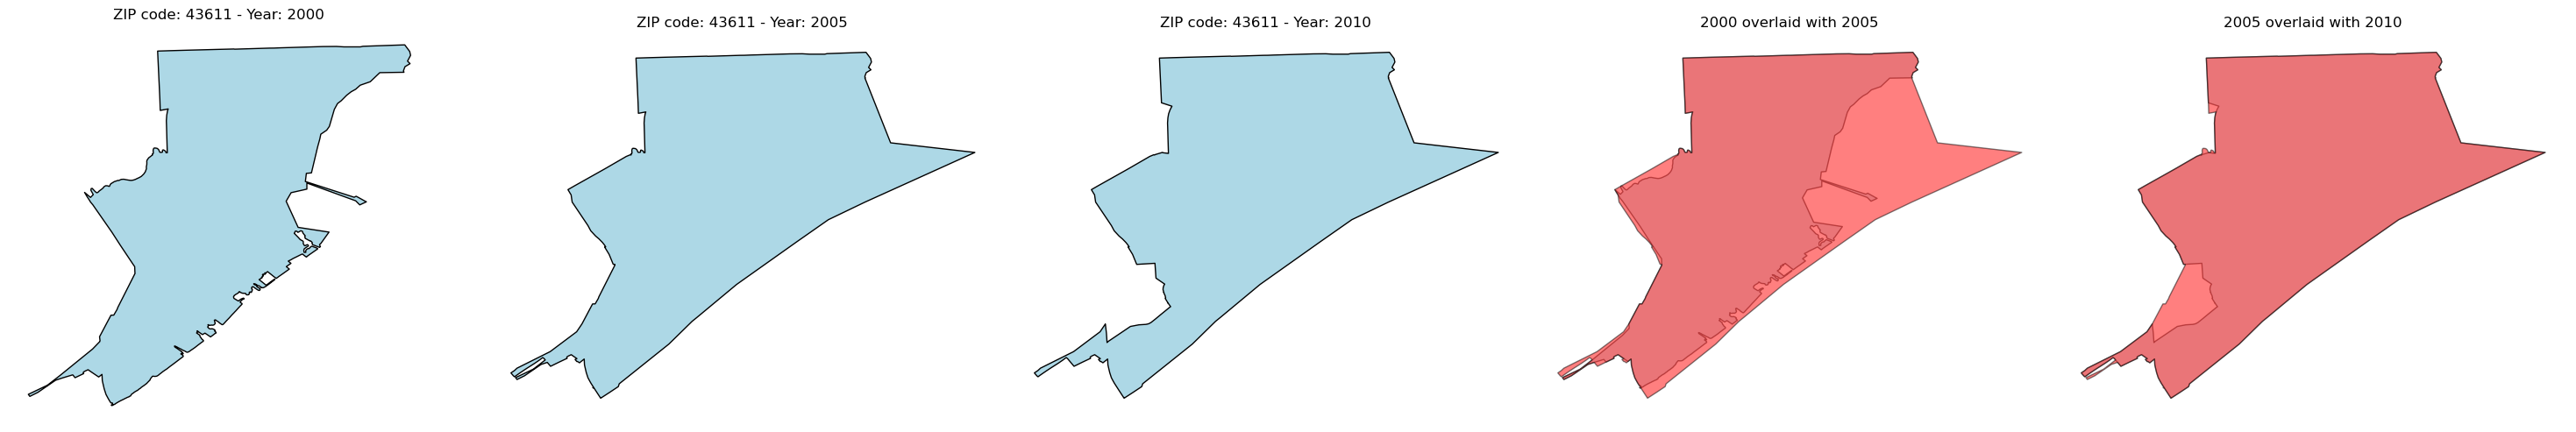

In [41]:
target_zipcode = '43611'
target_years = [2000, 2005, 2010]

# Create a larger figure with 5 subplots (3 for individual years + 2 for overlays)
fig, axes = plt.subplots(1, 5, figsize=(30, 5))

# Plot each year's geometry in the first 3 subplots
for i, year in enumerate(target_years):
    data = zipcode_df[(zipcode_df['ZIPcode'] == target_zipcode) & (zipcode_df['year'] == year)]
    if not data.empty:
        # Calculate and print the area of the geometry
        area = data['geometry'].area
        print(f"Plotting data for year {year} - Area: {area.iloc[0]}")
        # Plot the geometry
        data.plot(ax=axes[i], color='lightblue', edgecolor='black')
        axes[i].set_title(f'ZIP code: {target_zipcode} - Year: {year}')
    else:
        print(f"No data for year {year}")
    axes[i].axis('off')

# Overlay the 2005 geometry on the 2000 geometry
data_2000 = zipcode_df[(zipcode_df['ZIPcode'] == target_zipcode) & (zipcode_df['year'] == 2000)]
data_2005 = zipcode_df[(zipcode_df['ZIPcode'] == target_zipcode) & (zipcode_df['year'] == 2005)]
if not data_2000.empty and not data_2005.empty:
    data_2000.plot(ax=axes[3], color='lightblue', edgecolor='black', alpha=0.5)
    data_2005.plot(ax=axes[3], color='red', edgecolor='black', alpha=0.5)
    axes[3].set_title('2000 overlaid with 2005')

# Overlay the 2005 geometry on the 2010 geometry
data_2010 = zipcode_df[(zipcode_df['ZIPcode'] == target_zipcode) & (zipcode_df['year'] == 2010)]
if not data_2005.empty and not data_2010.empty:
    data_2010.plot(ax=axes[4], color='lightblue', edgecolor='black', alpha=0.5)
    data_2005.plot(ax=axes[4], color='red', edgecolor='black', alpha=0.5)
    axes[4].set_title('2005 overlaid with 2010')

axes[3].axis('off')
axes[4].axis('off')

plt.tight_layout()
plt.show()